In [1]:
import pandas as pd
import numpy as np
import random
import scipy
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from sklearn.utils import resample

%matplotlib inline

random.seed(42)

##  A/B тестирование

**Задание **

Провести аналогичные исследования но для чека покупок клиентов (колонки `revenue`)  
в интернет магазине есть 2-ва типа продуктов:
* 100 руб.
* 250 руб.

ну и конечно клиент может ничего не купить  
провести исследование изменился ли средний чек

 <a id='eda'></a>
### Первичный анализ данных

In [2]:
df = pd.read_csv('ab_datas.csv')
#df = df.loc[df['revenue']>0]
df.head(3)

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100


In [3]:
#количество посетителей всего
n_rows = [df.shape[0], df.loc[df['revenue']>0].shape[0], df.loc[df['revenue']==100].shape[0], 
          df.loc[df['revenue']==250].shape[0]]
print("Число строк: {}".format(n_rows))

Число строк: [294478, 171478, 85615, 85863]


In [4]:
# Сколько уникальных пользователей (уникальных `user_id`) в датасете?
user_total = df.nunique()['user_id']
print("Число уникальных пользователей : {}".format(user_total))

Число уникальных пользователей : 290584


Посетителей из контрольной `control` группы должны были направлять на страницу в старом дизайне  `old_page` , пользователей из тестовой группы `treatment` - на страницу в новом дизайне `new_page`. Проверим, были ли ошибки при направлении.

In [5]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Из тестовой группы неверно направлены {}".format(len(mismatch_1)) + " пользователей")

mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Из контрольной группы неверно направлены  {}".format(len(mismatch_2)) + " пользователей")


Из тестовой группы неверно направлены 1965 пользователей
Из контрольной группы неверно направлены  1928 пользователей


In [6]:
# пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   revenue       294478 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


In [7]:
# Конверсия по всем посетителям
p_all=df['converted'].mean()
print("Конверсия по всем посетителям: {} %".format(p_all*100))

Конверсия по всем посетителям: 11.96591935560551 %


In [8]:
df_grp = df.groupby('group')
df_grp.describe()

user_id                                                   \
              count           mean           std       min       25%   
group                                                                  
control    147202.0  788123.098035  91278.896888  630002.0  709287.0   
treatment  147276.0  787825.226283  91142.800641  630000.0  708729.5   

                                         converted            ...            \
                50%        75%       max     count      mean  ...  75%  max   
group                                                         ...             
control    788053.5  867155.50  945998.0  147202.0  0.120399  ...  0.0  1.0   
treatment  787837.5  866693.75  945999.0  147276.0  0.118920  ...  0.0  1.0   

            revenue                                                         
              count        mean         std  min  25%    50%    75%    max  
group                                                                       
control    147202.0   87.431896  102.424926  0.0  0.0    0.0  250.0  250.0  
treatment  147276.0  116.496238  102.732069  0.0  0.0  100.0  250.0  250.0  

[2 rows x 24 columns]

In [9]:
#объем тестовой группы для всех пользователей, 
#для пользователей совершивших покупку,
#для пользователей совершивших покупку на сумму 100р, 
#для пользователей совершивших покупку на сумму 250р
n_rows_treat = [len(df[df['group'] == 'treatment']), len(df[(df['group'] == 'treatment')&(df['revenue']>0)]),
               len(df[(df['group'] == 'treatment')&(df['revenue']==100)]),
               len(df[(df['group'] == 'treatment')&(df['revenue']==250)])]
#[df.shape[0], df.loc[df['revenue']>0].shape[0], df.loc[df['revenue']==100].shape[0], 
#          df.loc[df['revenue']==250].shape[0]]
#объем контрольной группы
n_rows_contr =  [a_i - b_i for a_i, b_i in zip(n_rows, n_rows_treat)]

print("Соотношение размеров тестовой и контрольной групп: {}".format([a_i - b_i for a_i, b_i in zip(n_rows_treat,n_rows_contr)]))

print("Вероятность, что новый пользователь будет направлен на версию со старым дизайном: {}".format([a_i / b_i for a_i, b_i in zip(n_rows_treat,n_rows)]))
print("Вероятность, что новый пользователь будет направлен на версию с новым дизайном: {}".format([a_i / b_i for a_i, b_i in zip(n_rows_contr,n_rows)]))


Соотношение размеров тестовой и контрольной групп: [74, 24676, 12547, 12129]
Вероятность, что новый пользователь будет направлен на версию со старым дизайном: [0.5001256460584492, 0.5719509208178308, 0.5732757110319453, 0.5706299570245624]
Вероятность, что новый пользователь будет направлен на версию с новым дизайном: [0.49987435394155083, 0.42804907918216917, 0.42672428896805464, 0.4293700429754376]


In [10]:
def conversion_calc(data):
    # Конверсия по всем посетителям
    p_all=data.loc[data['group'] == 'control','converted'].mean()
    print("Конверсия по пользователям контрольной группы: {} %".format(p_all*100))
    p_all=data.loc[data['group'] == 'treatment','converted'].mean()
    print("Конверсия по пользователям исследуемой группы: {} %".format(p_all*100))

    # с учетом неверно направленных
    p_all=data.loc[(data["group"] == 'control') & (data["landing_page"] == 'old_page'),'converted'].mean()
    print("Конверсия по пользователям направленным на старую версию сайта для контрольной группы: {} %".format(p_all*100))
    p_all=data.loc[(data["group"] == 'treatment') & (data["landing_page"] == 'new_page'),'converted'].mean()
    print("Конверсия по пользователям направленным на новую версию сайта для исследуемой группы: {} %".format(p_all*100))

In [11]:
conversion_calc(df)

Конверсия по пользователям контрольной группы: 12.039917935897611 %
Конверсия по пользователям исследуемой группы: 11.891957956489856 %
Конверсия по пользователям направленным на старую версию сайта для контрольной группы: 12.03863045004612 %
Конверсия по пользователям направленным на новую версию сайта для исследуемой группы: 11.880724790277405 %


Похоже конверсия для пользователей старой версии сайта больше, так что изменение версии сайта на первый взгляд не улучшило метрики даже с учетом неверно направленных.

In [12]:
# Конверсия по пользователям совершившим покупку 
conversion_calc(df.loc[df['revenue']>0])

Конверсия по пользователям контрольной группы: 12.0175474448577 %
Конверсия по пользователям исследуемой группы: 11.9263435871815 %
Конверсия по пользователям направленным на старую версию сайта для контрольной группы: 12.038148868921922 %
Конверсия по пользователям направленным на новую версию сайта для исследуемой группы: 11.911380240356298 %


In [13]:
# Конверсия по пользователям совершившим покупку на 100р
conversion_calc(df.loc[df['revenue']==100])

Конверсия по пользователям контрольной группы: 12.08463349208956 %
Конверсия по пользователям исследуемой группы: 11.786638414050243 %
Конверсия по пользователям направленным на старую версию сайта для контрольной группы: 12.121296193541227 %
Конверсия по пользователям направленным на новую версию сайта для исследуемой группы: 11.764220088778776 %


In [14]:
# Конверсия по пользователям совершившим покупку на 250р
conversion_calc(df.loc[df['revenue']==250])

Конверсия по пользователям контрольной группы: 11.95106735020479 %
Конверсия по пользователям исследуемой группы: 12.066291125806188 %
Конверсия по пользователям направленным на старую версию сайта для контрольной группы: 11.955835095718092 %
Конверсия по пользователям направленным на новую версию сайта для исследуемой группы: 12.058835698622202 %


Только для пользователей совершивших покупку на сумму 250 конверсия исследуемой группы стала выше(пользователи нового сайта более склонны совершать покупки дороже??)

<a id='si1'></a>
#### Формулировка рабочей гипотезы

Рабочая гипотеза в нашем случае может быть сформулирована, например, так: "Конверсия сайта со старым дизайном не меньше, чем с новым"

<a id='si4'></a>
#### Проведение вычислений. $Z$-критерий.

In [15]:
def z_stat_calc(data, n_rows_treat, n_rows_contr):
    convert_contr = sum(data.query("group == 'control'")['converted'])
    convert_treat = sum(data.query("group == 'treatment'")['converted'])

    z_score, p_value = sm.stats.proportions_ztest([convert_treat, convert_contr], [n_rows_treat, n_rows_contr], 
                                                  alternative='larger')

    print("Z-статистика={},  p_value={}".format(z_score, p_value))

In [16]:
#Z-статистикапо группам пользователей: все, совершившие покупки, покупка на 100 и покупка на 250
z_stat_calc(df, n_rows_treat[0], n_rows_contr[0])
z_stat_calc(df.loc[df['revenue']>0], n_rows_treat[1], n_rows_contr[1])
z_stat_calc(df.loc[df['revenue']==100], n_rows_treat[2], n_rows_contr[2])
z_stat_calc(df.loc[df['revenue']==250], n_rows_treat[3], n_rows_contr[3])


Z-статистика=-1.2369217547321678,  p_value=0.8919419336512124
Z-статистика=-0.5757759645661524,  p_value=0.7176166892124537
Z-статистика=-1.331252331588953,  p_value=0.9084470013266968
Z-статистика=0.5139770400702278,  p_value=0.30363402160314135


Для более дорогих покупок заметно явное улучшение для новой версии сайта. 

#### Проведение вычислений. $T$-test.

In [17]:
def t_test(data):
    t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(data.query("group == 'treatment'")['converted'],
                                                              data.query("group == 'control'")['converted'],
                                                              alternative="larger",
                                                              usevar='unequal')
    print("T-статистика={},  p_value={}".format(t_score, p_value))
    

In [18]:
#T-статистика по группам пользователей: все, совершившие покупки, покупка на 100 и покупка на 250
t_test(df)
t_test(df.loc[df['revenue']>0])
t_test(df.loc[df['revenue']==100])
t_test(df.loc[df['revenue']==250])

T-статистика=-1.2369191070650891,  p_value=0.8919409489056563
T-статистика=-0.5755004064089811,  p_value=0.7175231318187278
T-статистика=-1.3291460864668043,  p_value=0.9080981731234667
T-статистика=0.5142724737930437,  p_value=0.30353146608204074


#### Проведение вычислений. $Mann–Whitney$-test.

In [19]:
def mann_test(data):
    w_score, p_value = scipy.stats.mannwhitneyu(data.query("group == 'treatment'")['converted'], 
                             data.query("group == 'control'")['converted'],
                             alternative="greater")
    print("W-статистика={},  p_value={}".format(w_score, p_value))

In [20]:
#W-статистика по группам пользователей: все, совершившие покупки, покупка на 100 и покупка на 250
mann_test(df)
mann_test(df.loc[df['revenue']>0])
mann_test(df.loc[df['revenue']==100])
mann_test(df.loc[df['revenue']==250])

W-статистика=10823622516.0,  p_value=0.8919415509213815
W-статистика=3596192078.5,  p_value=0.7176161513900458
W-статистика=893890914.5,  p_value=0.9084457636310145
W-статистика=904208430.0,  p_value=0.3036351542273366


Для всех 3-х тестов p-value достаточно высок в случае обобщения всех данных - вероятность ошибки первого рода высока, следовательно сказать что старая версия сайта хуже новой можно только с очень высокой долей ошибок.

Но для покупок с revenu 250 все значительно меняется, и новый сайт показывает лучшие характеристики.

## bootstrap  

<function matplotlib.pyplot.show(close=None, block=None)>

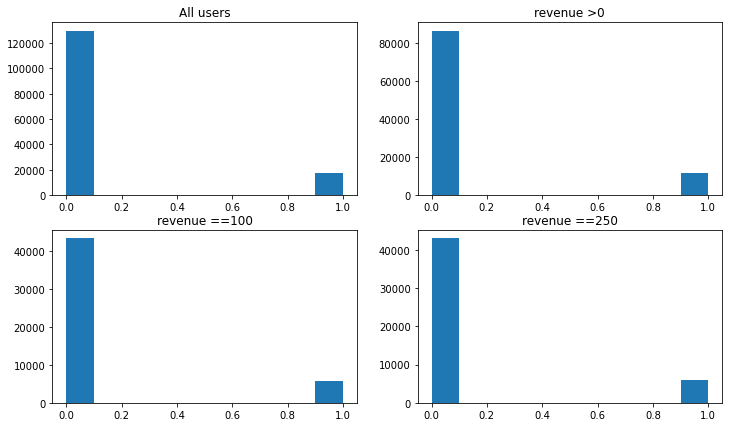

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7))

ax1.hist(df.loc[df['group']=='treatment', 'converted'])
ax1.set_title('All users')
ax2.hist(df.loc[(df['group']=='treatment')&(df['revenue']>0), 'converted'])
ax2.set_title('revenue >0')
ax3.hist(df.loc[(df['group']=='treatment')&(df['revenue']==100), 'converted'])
ax3.set_title('revenue ==100')
ax4.hist(df.loc[(df['group']=='treatment')&(df['revenue']==250), 'converted'])
ax4.set_title('revenue ==250')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

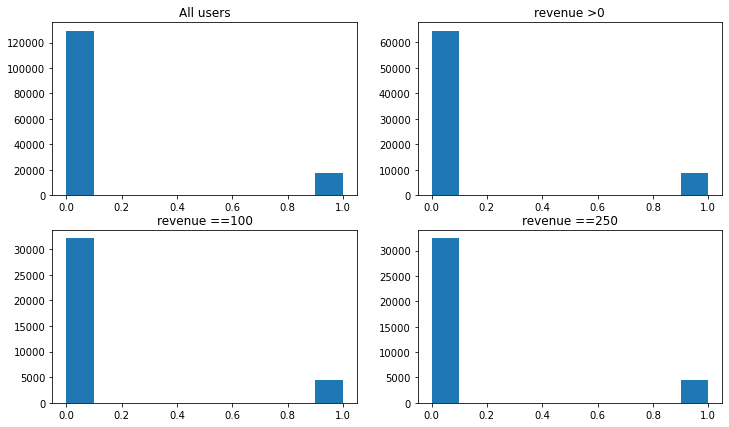

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7))

ax1.hist(df.loc[df['group']=='control', 'converted'])
ax1.set_title('All users')
ax2.hist(df.loc[(df['group']=='control')&(df['revenue']>0), 'converted'])
ax2.set_title('revenue >0')
ax3.hist(df.loc[(df['group']=='control')&(df['revenue']==100), 'converted'])
ax3.set_title('revenue ==100')
ax4.hist(df.loc[(df['group']=='control')&(df['revenue']==250), 'converted'])
ax4.set_title('revenue ==250')
plt.show

In [23]:
def calc_bost(data):
    b = data.loc[data['group']=='treatment', 'converted'].values
    a = data.loc[data['group']=='control', 'converted'].values
    a_means = []
    b_means = []

    for i in range(10000):
        a_boot = resample(a, replace=True, n_samples=len(a))
        b_boot = resample(b, replace=True, n_samples=len(b))

        a_means.append(a_boot.mean())
        b_means.append(b_boot.mean())

    a_means = np.array(a_means)
    b_means = np.array(b_means)
    plt.hist(a_means, label='A conv', alpha=0.5, bins=100)
    plt.hist(b_means, label='B conv', alpha=0.5, bins=100)

    plt.legend()
    plt.show()
    # доверительный интервал
    print(f'доверительный интервал - {np.percentile(a_means, 2.5)}, {np.percentile(a_means, 97.5)}')

    plt.hist(a_means - b_means, bins=100)
    plt.show()
    # сделаем оценку на p_value
    dff = a_means - b_means

    print(f'p_value - {len(dff[dff>=0])/len(dff)}')

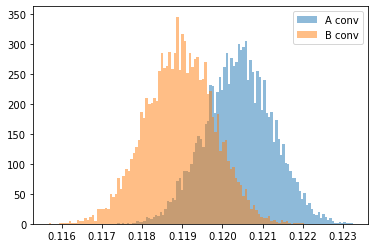

доверительный интервал - 0.11877556011467236, 0.12202959198923928


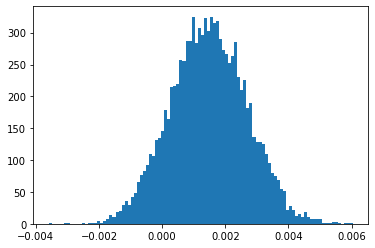

p_value - 0.8872


In [24]:
# По всей выборке
calc_bost(df)

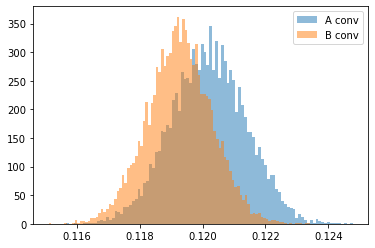

доверительный интервал - 0.11785908911322734, 0.12247789539652049


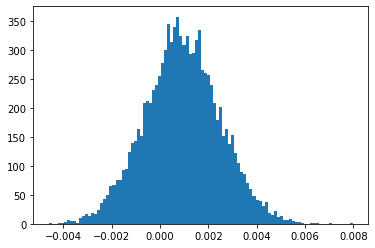

p_value - 0.7291


In [25]:
#совершившие покупки
calc_bost(df.loc[df['revenue']>0])

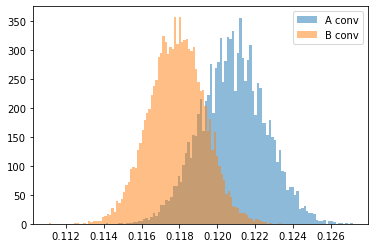

доверительный интервал - 0.11750697979963869, 0.12418569004215252


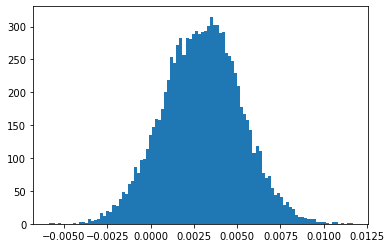

p_value - 0.9053


In [26]:
#покупка на 100
calc_bost(df.loc[df['revenue']==100])

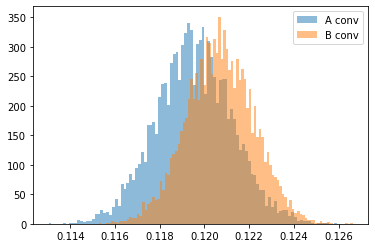

доверительный интервал - 0.11625573005669027, 0.12290123959096211


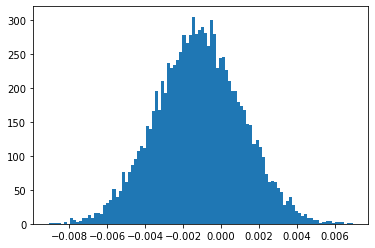

p_value - 0.3017


In [27]:
#покупка на 250
calc_bost(df.loc[df['revenue']==250])

А тут, очевидно, что новая версия сайта оказала существенное влияние на покупки по 100